In [1]:
# Load modules

import pickle
import torch
import torch.nn.functional as F
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms
import sys
import os
sys.path.append('..')
from types import SimpleNamespace
from field_of_junctions import FieldOfJunctions
import nbimporter

from torchsummary import summary

from Dataset_Maker_Lines import make_random_line_set, make_grey_transform

# %load_ext autoreload
# %reload_ext autoreload

dev = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
class LineDataset(torch.utils.data.Dataset):
    """ Dataset with support of transforms.
    """

    def __init__(self, images, params, boundaries, wedges, transform=None):
        self.images = images
        self.params = params
        self.boundaries = boundaries
        self.wedges = wedges
        self.transform = transform

    def __getitem__(self, index):
        
        image = self.images[index]
        wedge = self.wedges[index]

        if self.transform:
            image = self.transform(image)
            
        param = self.params[index].squeeze()
        boundary = self.boundaries[index]
        
        return image, param, boundary, wedge

    def __len__(self):
        return len(self.images)

In [6]:
def weights_init_uniform(m):
    classname = m.__class__.__name__
    # for every Linear layer in a model..
    if classname.find('LazyLinear') != -1:
        # apply a uniform distribution to the weights and a bias=0
        m.weight.data.uniform_(0.0, 1.0)
        m.bias.data.fill_(0) 
    if classname.find('Linear') != -1:
        # apply a uniform distribution to the weights and a bias=0
        m.weight.data.uniform_(0.0, 1.0)
        m.bias.data.fill_(0)
    if classname.find('Conv2d') != -1:
        # apply a uniform distribution to the weights and a bias=0
        m.weight.data.uniform_(0.0, 1.0)
        m.bias.data.fill_(0)
        

# Learn 8x8 patches

50000


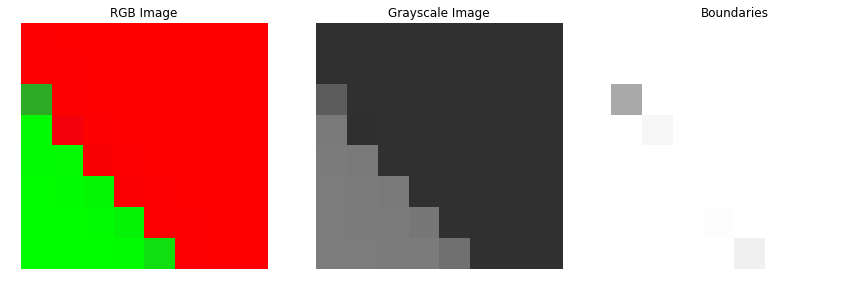

In [349]:
# Load dataset 

data_folder = 'foj_data/grayscale_lines/'

with open(data_folder + 'line_data_8_50000_grey_multicolor_noiseless_uncentered.pkl','rb') as f:
    data = pickle.load(f)

# wedges = data['wedges']
wedges_grey = data['wedges_grey']
params = data['params']
boundaries = data['boundaries']
wedges = data['wedges']


line_data = LineDataset(wedges_grey, params, boundaries, wedges)#, transform=trainTransform)
data_size = len(line_data)

print(data_size)

train_proportion = .85
# Split dataset into training and testing
train_dataset, test_dataset = torch.utils.data.random_split(line_data, [int(data_size*train_proportion), int(data_size*(1-train_proportion))], generator=torch.Generator().manual_seed(42))

# Create loaders for the training and testing data
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=1000, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=500, shuffle=False) #len(test_dataset)


W,H = 8,8

img_show = 2
plt.figure(figsize=[15, 15])
plt.subplot(131)
plt.imshow(wedges[img_show,:,:].squeeze().permute(1,2,0).cpu())
plt.title('RGB Image')
plt.axis('off');
plt.subplot(132)
plt.imshow(wedges_grey[img_show,:,:].squeeze().cpu(),cmap='gray', vmin=0, vmax=1)
plt.title('Grayscale Image')
plt.axis('off');
plt.subplot(133)
plt.imshow(boundaries[img_show,:,:].squeeze().cpu(),cmap='gray', vmin=0, vmax=1)
plt.title('Boundaries')
plt.axis('off');


In [427]:
class offCenterLineNet(nn.Module):

    def __init__(self):
        super().__init__()
                
        self.conv1 = nn.Conv2d(1, 8, kernel_size=3) #64 is good
        self.conv2 = nn.Conv2d(8, 8, kernel_size=3)
        self.conv3 = nn.Conv2d(8, 1, kernel_size=3)
        self.fc = nn.LazyLinear(3)
        self.maxpool = nn.MaxPool2d(2)
#         self.avgpool = nn.AvgPool2d(2)
        self.activate = nn.ReLU()
#         self.batchnorm = nn.BatchNorm2d(128)
    
    def forward(self, x):

        x = self.conv1(x)
#         x = F.relu(x)
        x = self.activate(x)
#         x = self.maxpool(x)
#         x = self.batchnorm(x)
        x = self.conv2(x)
        x = self.activate(x)
#         x = F.relu(x)
#         x = self.batchnorm(x)
        x = self.conv3(x)
        x = self.activate(x)
#         x = self.maxpool(x)
#         x = self.avgpool(x)
        x = x.view(x.shape[0],-1)
        
        x = self.fc(x)
         
        # We're defining
        # a = - sin(theta)
        # b = cos(theta)
        # c = -cy*cos(theta)+cx*sin(theta)
        # Hence, we want to normalize the vector by 1/sqrt(a^2 + b^2)
        norm_factor = (torch.norm(x[:,:2],p=2,dim=1)).unsqueeze(1)       
        out = x/(norm_factor)#+eps)
#         print('Output shape=',x.shape)

#         out = x
        
        return out
    
model = offCenterLineNet()
model = model.to(dev)
summary(model, input_size=(1, H, W))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1              [-1, 8, 6, 6]              80
              ReLU-2              [-1, 8, 6, 6]               0
            Conv2d-3              [-1, 8, 4, 4]             584
              ReLU-4              [-1, 8, 4, 4]               0
            Conv2d-5              [-1, 1, 2, 2]              73
              ReLU-6              [-1, 1, 2, 2]               0
            Linear-7                    [-1, 3]              15
Total params: 752
Trainable params: 752
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.00
Estimated Total Size (MB): 0.01
----------------------------------------------------------------


In [428]:
# Now let's train the initial network 

model = offCenterLineNet()
model = model.to(dev)
model.apply(weights_init_uniform)

model.train();

optimizer = torch.optim.Adam(model.parameters(),lr=.01) 
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=500, gamma=0.1)

n_epochs = 2400

mse_loss = nn.MSELoss()
ce_loss = nn.CrossEntropyLoss()

for epoch in range(0,n_epochs):  # loop over the dataset multiple times
    
    if epoch == 0:
        train_loss_over_time = [] # to track the loss as the network trains
        test_loss_over_time = []
        
    if epoch == 5:
        optimizer = torch.optim.Adam(model.parameters(),lr=.001) 
        
        
    running_loss = 0
    num_batches = 0
    
    for batch_i, data in enumerate(train_loader):
        
        # get the input images and their corresponding labels
        num_batches += 1

        inputs, output_gt, _, _ = data
        inputs, output_gt = inputs.to(dev), output_gt.to(dev)
        
        # zero the parameter (weight) gradients
        optimizer.zero_grad()
        
        # forward pass to get outputs
        output_line_params = model(inputs)
        

        # make the ground truth
        c = -output_gt[:,2]*torch.cos(output_gt[:,0]) + output_gt[:,1]*torch.sin(output_gt[:,0])
        gt_line_params = torch.stack((-torch.sin(output_gt[:,0]),torch.cos(output_gt[:,0]),c),dim=1)
        
        # calculate the loss
#         print(output_line_params[:,:,0,50])
        
        loss = mse_loss(output_line_params,gt_line_params)
        
        # backward pass to calculate the parameter gradients
        loss.backward()

        # update the parameters
        optimizer.step()

        # to convert loss into a scalar and add it to running_loss, we use .item()
        running_loss += loss.item()
      

#     scheduler.step()
    
    # Calculate test data loss after each epoch
    with torch.no_grad():
        test_loss = 0
        num_batches_test = 0
        for batch_i, data in enumerate(test_loader):
            num_batches_test += 1

            # Add code here
            inputs, output_gt, _, _ = data
            inputs, output_gt = inputs.to(dev), output_gt.to(dev)


            # zero the parameter (weight) gradients
            optimizer.zero_grad()

            # forward pass to get outputs
            output_line_params = model(inputs)

            # make the ground truth
            c = -output_gt[:,2]*torch.cos(output_gt[:,0]) + output_gt[:,1]*torch.sin(output_gt[:,0])
            gt_line_params = torch.stack((-torch.sin(output_gt[:,0]),torch.cos(output_gt[:,0]),c),dim=1)
    

            # calculate the loss
    #         print(output_line_params[:,:,0,50])

            loss = mse_loss(output_line_params,gt_line_params)
            
            test_loss += loss
                    
        test_loss_over_time.append(test_loss/num_batches_test)

    # Calculate model loss:
    avg_loss = running_loss/num_batches
    train_loss_over_time.append(avg_loss)
    
#     print('Epoch: {}, Avg. Train Loss: {},'.format(epoch + 1, train_loss_over_time[-1]))


    print('Epoch: {}, Avg. Train Loss: {}, Avg. Test Loss: {}'.format(epoch + 1, train_loss_over_time[-1], test_loss_over_time[-1]))
    
print('Finished Training')

plt.figure()
plt.semilogy(np.arange(0,n_epochs),train_loss_over_time[0:])
plt.semilogy(np.arange(0,n_epochs),test_loss_over_time[0:])
plt.legend(['Training loss', 'Testing loss'])

Epoch: 1, Avg. Train Loss: 0.6965098131534665, Avg. Test Loss: 0.680701494216919
Epoch: 2, Avg. Train Loss: 0.5836883901163589, Avg. Test Loss: 0.4644274413585663
Epoch: 3, Avg. Train Loss: 0.4415113309095072, Avg. Test Loss: 0.3575354516506195
Epoch: 4, Avg. Train Loss: 0.27800611631814826, Avg. Test Loss: 0.19512107968330383
Epoch: 5, Avg. Train Loss: 0.1956608756337055, Avg. Test Loss: 0.10213398188352585
Epoch: 6, Avg. Train Loss: 0.08646701432244722, Avg. Test Loss: 0.07712095230817795
Epoch: 7, Avg. Train Loss: 0.07281068747126779, Avg. Test Loss: 0.06747876852750778
Epoch: 8, Avg. Train Loss: 0.06355564270255178, Avg. Test Loss: 0.0590297132730484
Epoch: 9, Avg. Train Loss: 0.055695659372695654, Avg. Test Loss: 0.051834624260663986
Epoch: 10, Avg. Train Loss: 0.04900221084786016, Avg. Test Loss: 0.04581208899617195
Epoch: 11, Avg. Train Loss: 0.043445293293442835, Avg. Test Loss: 0.04078725352883339
Epoch: 12, Avg. Train Loss: 0.03882752800750178, Avg. Test Loss: 0.0365909859538

Epoch: 97, Avg. Train Loss: 0.008485668035613935, Avg. Test Loss: 0.008294139988720417
Epoch: 98, Avg. Train Loss: 0.008434612780462864, Avg. Test Loss: 0.008093791082501411
Epoch: 99, Avg. Train Loss: 0.008365551811144796, Avg. Test Loss: 0.00811715517193079
Epoch: 100, Avg. Train Loss: 0.008348353813553965, Avg. Test Loss: 0.00804741308093071
Epoch: 101, Avg. Train Loss: 0.008317836657772923, Avg. Test Loss: 0.007996665313839912
Epoch: 102, Avg. Train Loss: 0.00822690051308898, Avg. Test Loss: 0.007951953448355198
Epoch: 103, Avg. Train Loss: 0.008210986289520597, Avg. Test Loss: 0.007945407181978226
Epoch: 104, Avg. Train Loss: 0.008197840638891903, Avg. Test Loss: 0.007904816418886185
Epoch: 105, Avg. Train Loss: 0.008146489916239367, Avg. Test Loss: 0.007839766331017017
Epoch: 106, Avg. Train Loss: 0.008155792810802543, Avg. Test Loss: 0.007884092628955841
Epoch: 107, Avg. Train Loss: 0.008088685832051344, Avg. Test Loss: 0.007828870788216591
Epoch: 108, Avg. Train Loss: 0.0080508

KeyboardInterrupt: 

[tensor(2.5448), tensor(2.5487), tensor(2.5083), tensor(2.4894), tensor(2.5643), tensor(2.5325), tensor(2.4974), tensor(2.4372), tensor(2.4108), tensor(2.4227), tensor(2.4508), tensor(2.4160), tensor(2.4459), tensor(2.4696), tensor(2.5512)]


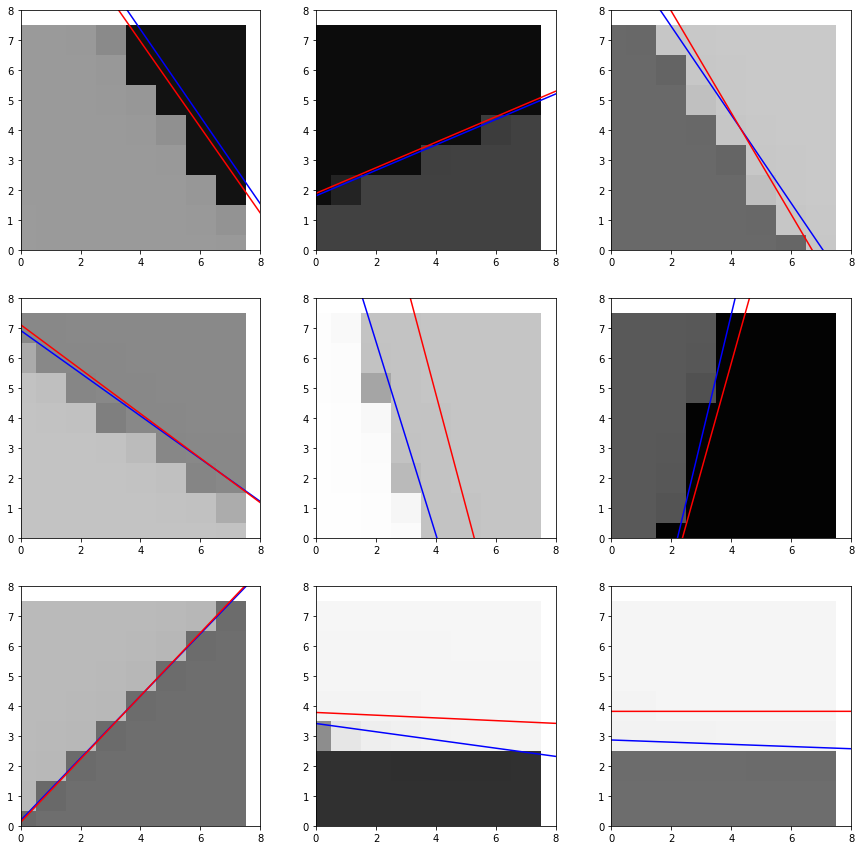

In [429]:
# Plot the Results

model.eval();

ang_loss_all = []

for batch_i, data in enumerate(test_loader):
    # get the input images and their corresponding labels
    inputs, output_gt, _, _ = data
    inputs, output_gt = inputs.to(dev), output_gt.to(dev)
    

    # forward pass to get outputs
    outputs = model(inputs).squeeze().detach().cpu()
    
    gt = output_gt.cpu().squeeze()
    
    c = -output_gt[:,2]*torch.cos(output_gt[:,0]) + output_gt[:,1]*torch.sin(output_gt[:,0])
    angle_params = torch.stack((-torch.sin(output_gt[:,0]),torch.cos(output_gt[:,0]),c),axis=1).detach().cpu()
  
    # Calculate angular loss
    ang_loss = torch.mean(torch.abs(torch.rad2deg(torch.atan2(-angle_params[:,0]*outputs[:,1] + angle_params[:,1]*outputs[:,0]
                                         ,angle_params[:,1]*outputs[:,1]+angle_params[:,0]*outputs[:,0]).cpu())))

    ang_loss_all.append(ang_loss)

    
print(ang_loss_all)

plt.figure(figsize=[15, 15])

for ii in range(9):
    
    plt.subplot(3,3,ii+1)
    plt.imshow(inputs[ii].cpu().squeeze(),cmap='gray', vmin=0, vmax=1)
    
    # Plot the ground truth lines
    x_sample = torch.linspace(-1,1,inputs.shape[-1])
    y_sample = -angle_params[ii,0]/angle_params[ii,1]*x_sample - angle_params[ii,2]/angle_params[ii,1]
    
    plt.plot(x_sample*W/2+W/2,y_sample*W/2+W/2,'b')
    plt.xlim([0,W])
    plt.ylim(([0,W]))
    
    # Plot the estimated lines
    y_est = -outputs[ii,0]/outputs[ii,1]*x_sample - outputs[ii,2]/outputs[ii,1]
    plt.plot(x_sample*W/2+W/2,y_est*W/2+W/2,'r')



In [ ]:
# %load_ext autoreload
# %reload_ext autoreload

tensor([[[[ 0.9182]],

         [[-0.0676]],

         [[ 0.0118]]]]) tensor(52.6107)


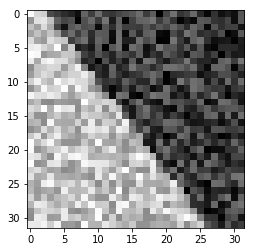

In [575]:
# Extract the network weights and process on a larger image:

# First produce a larger image:

R = 32
add_noise = 1
centered = 0
random_colors = 1
num_samples = 1

dists,wedges,boundaries,params = make_random_line_set(num_samples,R,'cpu',centered)

grey_transform = make_grey_transform(num_samples,wedges,'cpu',random_colors).unsqueeze(-1).unsqueeze(-1)

wedges_grey = (wedges[:,:2,:,:,:,:]*grey_transform).sum(1).squeeze(1)

if add_noise:
    wedges_grey = wedges_grey + .8*torch.rand(num_samples).unsqueeze(1).unsqueeze(1).unsqueeze(1)*torch.rand(*wedges_grey.shape)#,device=dev)
    mn, mx = wedges_grey.min(), wedges_grey.max()

    # Adjust contrast (equally to both images)
    wedges_grey = (wedges_grey - mn) / (mx - mn) 

plt.figure()
plt.imshow(wedges_grey.squeeze(),cmap='gray', vmin=0, vmax=1)

wedges_grey = wedges_grey.to(dev)

print(params,torch.rad2deg(params[0,0,0,0]))



In [582]:
class offCenterLineNetBig(nn.Module):

    def __init__(self):
        super().__init__()
                
        self.conv1 = nn.Conv2d(1, 8, kernel_size=3) #64 is good
        self.conv2 = nn.Conv2d(8, 8, kernel_size=3)
        self.conv3 = nn.Conv2d(8, 1, kernel_size=3)
        self.conv4 = nn.Conv2d(1, 3, kernel_size=2)
#         self.avgpool = nn.AvgPool2d(2)
        self.activate = nn.ReLU()
#         self.batchnorm = nn.BatchNorm2d(128)
    
    def forward(self, x):
        
        x = self.conv1(x)
        x = self.activate(x)
        x = self.conv2(x)
        x = self.activate(x)
        x = self.conv3(x)
        x = self.activate(x)
        x = self.conv4(x)
        
        # We're defining
        # a = - sin(theta)
        # b = cos(theta)
        # c = -cy*cos(theta)+cx*sin(theta)
        # Hence, we want to normalize the vector by 1/sqrt(a^2 + b^2)
        norm_factor = (torch.norm(x[:,:2,:,:],p=2,dim=1)).unsqueeze(1)    
        out = x/(norm_factor)#+eps)

        return out
    
big_model = offCenterLineNetBig()
big_model = big_model.to(dev)
summary(big_model, input_size=(1, R, R))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 30, 30]              80
              ReLU-2            [-1, 8, 30, 30]               0
            Conv2d-3            [-1, 8, 28, 28]             584
              ReLU-4            [-1, 8, 28, 28]               0
            Conv2d-5            [-1, 1, 26, 26]              73
              ReLU-6            [-1, 1, 26, 26]               0
            Conv2d-7            [-1, 3, 25, 25]              15
Total params: 752
Trainable params: 752
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.23
Params size (MB): 0.00
Estimated Total Size (MB): 0.24
----------------------------------------------------------------


In [399]:
# for name, child in model.named_children():
#             for name2, params in child.named_parameters():
#                 print(name, name2)
                
# for name, child in big_model.named_children():
#             for name2, params in child.named_parameters():
#                 print(name, name2)
                

In [588]:
offCenterLineNetWeights = model.state_dict()
offCenterLineNetWeightsBig = big_model.state_dict()

with torch.no_grad():
    big_model.conv1.weight.copy_(offCenterLineNetWeights['conv1.weight'])
    big_model.conv1.bias.copy_(offCenterLineNetWeights['conv1.bias'])
    big_model.conv2.weight.copy_(offCenterLineNetWeights['conv2.weight'])
    big_model.conv2.bias.copy_(offCenterLineNetWeights['conv2.bias'])
    big_model.conv3.weight.copy_(offCenterLineNetWeights['conv3.weight'])
    big_model.conv3.bias.copy_(offCenterLineNetWeights['conv3.bias'])
    big_model.conv4.weight.copy_(offCenterLineNetWeights['fc.weight'].view(offCenterLineNetWeightsBig['conv4.weight'].shape))
    big_model.conv4.bias.copy_(offCenterLineNetWeights['fc.bias'])
    

In [463]:
# # Verify that the model outputs are the same when the input size is the patch size

# c = -params[:,2]*torch.cos(params[:,0]) + params[:,1]*torch.sin(params[:,0])
# gt_params = torch.stack((-torch.sin(params[:,0]),torch.cos(params[:,0]),c),axis=1).detach().cpu()
    
# print(gt_params)    

# print(big_model(wedges_grey).cpu().detach())
# print(model(wedges_grey).cpu().detach())

In [581]:
print(big_model(wedges_grey).shape)
print(wedges_grey.shape)

torch.Size([1, 3, 25, 25])
torch.Size([1, 1, 32, 32])


In [590]:
# Make Transformation matrix L

# Each patch needs to be transformed by a different 3 x 3 transformation
# Assuming zero-padding, the output of the network will 64 x 64 x 3
# The transformation will be 64 x 64 x 3 x 3
# Hence, we need to add an additional input to the dimension to make it: 64 x 64 x 1 x 3

num_convs = 3.5
Wn,Hn = big_model(wedges_grey).shape[-1],big_model(wedges_grey).shape[-1]


# First define the center of the global coordinate system
xa,ya = torch.zeros((Wn,Hn),device='cpu'),torch.zeros((Wn,Hn),device='cpu')

# First, let's make the transformation matrix:
y0, x0 = torch.meshgrid([torch.linspace(-1.0+num_convs/W, 1.0-num_convs/W, Wn, device='cpu'),
                               torch.linspace(-1.0+num_convs/H, 1.0-num_convs/H, Hn, device='cpu')])

L = torch.zeros((1,3,3,Hn,Wn),device='cpu')#torch.tensor([[1-x0,0,0],[0,1-y0,0],[0,0,1]])
L[:,0,0,:,:] = 1
L[:,1,1,:,:] = 1
L[:,2,2,:,:] = 1
L[:,0,2,:,:] = -x0+xa
L[:,1,2,:,:] = -y0+ya

# ---- Testing

A = torch.rand(10,1,3,Wn,Hn,device='cpu')

print(A.shape)
print(L.shape)

out = torch.einsum('aijbc,ajkbc->aikbc',A,L)

print(out.shape)

torch.Size([10, 1, 3, 25, 25])
torch.Size([1, 3, 3, 25, 25])
torch.Size([10, 1, 3, 25, 25])


torch.Size([1, 3, 25, 25])


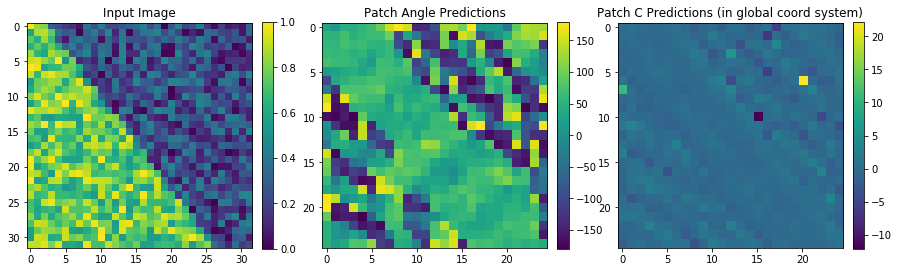

In [591]:
output_line_params = big_model(wedges_grey).cpu().detach()

print(output_line_params.shape)

# I need to transform this into a global coordinate system

# transform each patch into global coordinate system
output_line_params_T = torch.einsum('ajbc,ajkbc->akbc',output_line_params,L)

# output_line_params_plot = output_line_params_trans.clone() + 1
# output_line_params_plot = output_line_params_plot/torch.max(output_line_params_plot)

output_line_angles = torch.rad2deg(torch.atan2(-output_line_params[0,0,:,:],output_line_params[0,1,:,:]))
output_line_disp = output_line_params_T[0,2,:,:]


plt.figure(figsize=[15,15])
plt.subplot(131)
plt.imshow(wedges_grey.cpu().detach().squeeze())
plt.title('Input Image')
plt.colorbar(fraction=0.046, pad=0.04)
plt.subplot(132)
plt.imshow(output_line_angles)
plt.title('Patch Angle Predictions')
plt.colorbar(fraction=0.046, pad=0.04)
plt.subplot(133)
plt.imshow(output_line_disp)
plt.title('Patch C Predictions (in global coord system)')
plt.colorbar(fraction=0.046, pad=0.04)


Text(0.5, 1.0, 'Parameter Error')

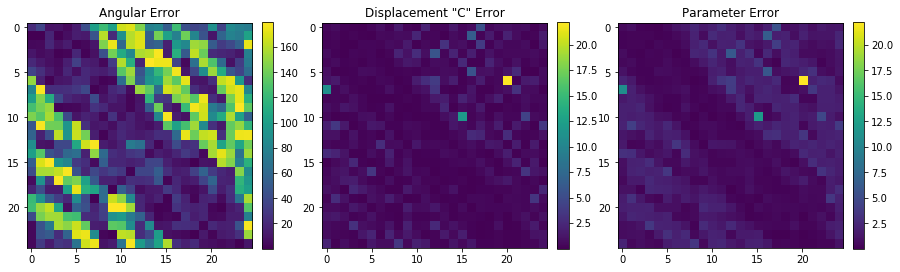

In [592]:
c = -params[:,2]*torch.cos(params[:,0]) + params[:,1]*torch.sin(params[:,0])
gt_params = torch.stack((-torch.sin(params[:,0]),torch.cos(params[:,0]),c),axis=1).detach().cpu()
    

# Calculate angular loss
ang_loss = torch.abs(torch.rad2deg(torch.atan2(-gt_params[:,0]*output_line_params_T[:,1] + gt_params[:,1]*output_line_params_T[:,0]
                                     ,gt_params[:,1]*output_line_params_T[:,1]+gt_params[:,0]*output_line_params_T[:,0]).cpu())).squeeze()

    
plt.figure(figsize=[15,15])
plt.subplot(131)
plt.imshow(ang_loss)
plt.title('Angular Error')
plt.colorbar(fraction=0.046, pad=0.04)
plt.subplot(132)
plt.imshow(torch.abs(c-output_line_params_T[:,2]).squeeze())
plt.colorbar(fraction=0.046, pad=0.04)
plt.title('Displacement "C" Error')
plt.subplot(133)
plt.imshow(torch.norm(output_line_params_T-gt_params,dim=1).squeeze())
plt.colorbar(fraction=0.046, pad=0.04)
plt.title('Parameter Error')



gt C= tensor([[[0.3896]]])
center C= tensor(1.6575)
median C= tensor(0.2828)
gt angle= tensor([[278.9931]])
center angle= tensor(-153.8058)
median angle= tensor(-85.3454)


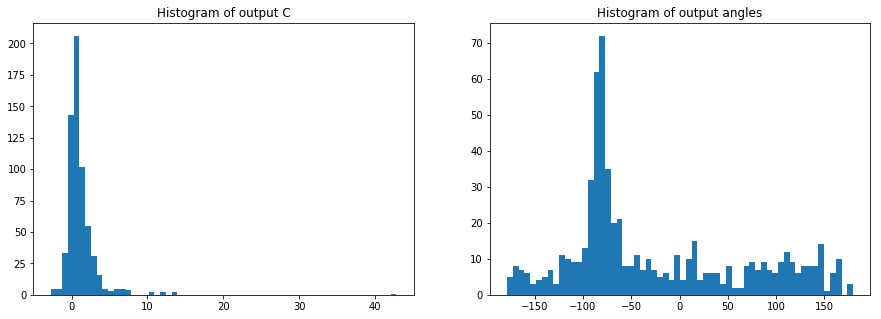

In [571]:
# Make C histogram

plt.figure(figsize=[15,5])
plt.subplot(121)
plt.hist(output_line_params_T.squeeze()[2,:,:].ravel(),bins=60);
plt.title('Histogram of output C')

print('gt C=',c)
print('center C=',output_line_disp[16,16])

weight=torch.histogram(output_line_params_T.ravel(), bins=60)
print('median C=',weight[1][torch.argmax(weight[0])])


# Next, angles:

plt.subplot(122)
plt.hist(output_line_angles.ravel(),bins=60)
plt.title('Histogram of output angles')

print('gt angle=',torch.rad2deg(params[0][0]))
print('center angle=',output_line_angles[16,16])

weight=torch.histogram(output_line_angles.ravel(), bins=100)
print('median angle=',weight[1][torch.argmax(weight[0])])